# Full Tutorial

This notebook aims to show all the features of `panama`, and especially how they interplay.

## Installation
Installing `panama` is easy, just run 
```bash
pip install corsika-panama
```
Or install it by cloning, so you also have access to the install script for CORSIKA7.
```bash
git clone git@github.com:The-Ludwig/PANAMA.git
cd PANAMA
pip install -e .
```

### CORSIKA7
For this notebook to make sense, you need a CORSIKA7 installation (preferably with the `EHIST` option). 
If you cloned the `panama` repository in the last step, you can easily download and install a pre-configured version (EHIST, SIBYLL2.3d, CURVED, URQDM) of CORSIKA7. You need to have a FORTRAN compiler installed:
```
CORSIKA_VERSION=77500 CORSIKA_PW= admin/download_corsika.sh
```
This will install CORSIKA7 in the folder `corsika-77500`. You oviously need the CORSIKA_PW, which you will get by mail, after requesting to be on the CORSIKA7 mailing list, [as described on their website here](https://www.iap.kit.edu/corsika/79.php).

## Generating a CORSIKA7 Muon Simulation
`panama` provides two ways of executing CORSIKA7 (in parallel). You can either use the Command Line Interface (CLI), available through `panama run` after installation, or you can do it inside python via an `CorsikaRunner` object.
The CLI itself is only a small wrapper around `panama.CorsikaRunner`. This tutorial focuses on the use of `CorsikaRunner`, but translating the code to a `panama` command, is straightforeward. For that, have a look at `panama run --help`.

### CORSIKA Steering Cards
Now that you have a workin CORSIKA7 simulation, you need to tell CORSIKA what settings to use. The current version of `panama` follows the philosphy to controll CORSIKA7 exactly as you would when using CORSIKA7 directly -- Except for the necesarry modifications for parallelization to work; This means that you have to write a CORSIKA7 steering card. Consider the following example
```
RUNNR   {run_idx}                      run number
EVTNR   {first_event_idx}              number of first shower event
NSHOW   {n_show}                       number of showers to generate
PRMPAR  {primary}                      particle type of prim. particle
ESLOPE  -1                             slope of primary energy spectrum
ERANGE  1.E4  1.E9                     energy range of primary particle
THETAP  0.     0.                      range of zenith angle (degree)
PHIP    -180.  180.                    range of azimuth angle (degree)
SEED    {seed_1}   0   0               seed for 1. random number sequence
SEED    {seed_2}   0   0               seed for 2. random number sequence
OBSLEV  110.E2                         observation level (in cm)
FIXCHI  0.                             starting altitude (g/cm**2)
MAGNET  16.811  -51.890                magnetic field at south pole (IceCube)
HADFLG  0  0  0  0  0  2               flags hadr.interact.&fragmentation
ECUTS   1.0E3  1.0E3  1.0E20  1.0E20   energy cuts for particles
MUADDI  T                              additional info for muons
MUMULT  T                              muon multiple scattering angle
ELMFLG  T   T                          em. interaction flags (NKG,EGS)
STEPFC  1.0                            mult. scattering step length fact.
RADNKG  200.E2                         outer radius for NKG lat.dens.distr.
LONGI   F  10.  F  F                   longit.distr. & step size & fit & out
MAXPRT  1                              max. number of printed events
DIRECT  {dir}                          output directory
USER    you                            user
DEBUG   F  6  F  1000000               debug flag and log.unit for out
EXIT                                   terminates input
```
For explanation what each setting does specifically, refer to the [CORSIKA7 userguide](https://web.iap.kit.edu/corsika/usersguide/usersguide.pdf).
The important thing is, that `panama` replaces `{run_idx}, {first_event_idx}, {n_show}, {primary}, {seed_1}, {seed_2}` and `{dir}` correctly for parallelization.
In theory, `panama` works when only providing `{run_idx}, {n_show}, {seed_1}, {seed_2}`, although it is adviced to leave the other templates in the card, as only then the full functionality of `panama` is available. 

**TLDR;** You can use every normal CORSIKA7 steering card, as long as you add at least `{run_idx}, {n_show}, {seed_1}, {seed_2}` at the arguments as in the card above, and optionally (but required for `panama` to work as expected) `{first_event_idx}, {primary}, {dir}`.

### Starting the CORSIKA Simulation
This notebook will use the CORSIKA7 Steering card from above, which is located in the `panama` repository under `tests/files`.

In [1]:
import panama as pn

# This is to have convenient access to the PDGIDs
from particle import Particle, literals
from pathlib import Path

The following cell performs the CORSIKA7 simulation. On my laptop with an AMD Ryzen 7 5700U CPU with 8 Physical cores (and 16 threads),
the simulation took about 13 minutes with 15 threads. Consider changing n_jobs to a suitable value for your set up.

remember to execute `rm -r corsika_output`, should you want to re-run the cell. This is not done automatically by `panama`, since deleting simulations, might come at a heavy cost and should always be done manually. (I speak from experience! :0)

In [2]:
if Path("./corsika_output/").exists():
    print("Simulations exist, I will reuse them, instead of generating new ones.")
else:
    # Run 1000 Showers each with the 4 leading elements of the GSF CR flux model
    # This is done in a context-manager, alternatively, you could also just construct an object
    # and call "clean"
    with pn.CorsikaRunner(
        primary={
            literals.proton.pdgid: 1000,
            Particle.from_nucleus_info(z=2, a=4).pdgid: 1000,  # Helium-4
            Particle.from_nucleus_info(z=8, a=16).pdgid: 1000,  # Oxygen-16
            Particle.from_nucleus_info(z=26, a=56).pdgid: 1000,  # Iron-56
        },
        n_jobs=15,  # Number of jobs to submit to the OS
        template_path="../../tests/files/example_corsika.template",  # This is the steering card from above
        output="./corsika_output",  # Produced DAT files go here
        corsika_executable="../../corsika-77500/run/corsika77500Linux_SIBYLL_urqmd",  # path to the compiled corsika exectuble
        corsika_tmp_dir="/tmp/corsika_tmp_dir/",  # some temporary path,
        seed=1701,
    ) as runner:
        runner.run()

Simulations exist, I will reuse them, instead of generating new ones.


### Reading in the Simulation
The following cell reads in the simulated data, and puts it to three pandas DataFrames.
`run_header` contains the information from corsikas RUN HEADER, `event_header` that from corsikas EVENT HEADER,
and `particles` is a list of all simulated particles reaching the ground level.
Since we simulated with `EHIST`, `panama` could read in the history information correctly, and with `mother_columns=True` add the 
information to each particle column-wise. With the default options, the particles DataFrame does not contain the mother particles, only 
ground level particles. For further options, have a look at its documentation.

`panama` makes use of pandas MultiIndex (for better or worse). This means, that the index of run_header is a single number (`run_number`), while 
the index of event_header is two numbers (`run_number`, `event_number`). Finally, particle has a three-touple index (`run_number`, `event_number`, `particle_number`). 
The use of pandas MultiIndex allows syntax like `particles["primary_energy"] = event_number["total_energy"]` to work as expected. At times, it can be confusing, though. You can then consider to also add them as normal columns with `particles["run_idx"] = particles.index.get_level_values(0)`.

In [3]:
run_header, event_header, particles = pn.read_DAT(
    glob="corsika_output/DAT*", mother_columns=True
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000.0 [00:00<00:00, 14886.29it/s]


Let's see what the simulated data looks like.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Text(0.5, 0, 'Particle Type')

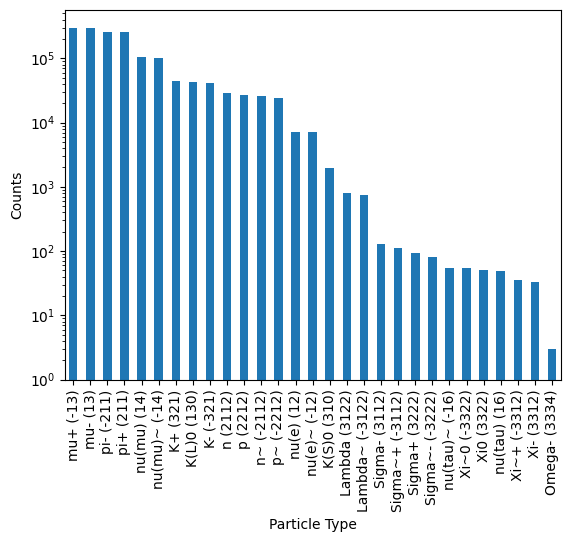

In [5]:
# Let's see what kind of particles we have in the simulation
counts = particles["pdgid"].value_counts()
counts.index = counts.index.map(
    lambda pid: (
        f"{Particle.from_pdgid(pid).name} ({pid})" if pid != 0 else "unknown (0)"
    )
)
counts.plot(kind="bar", log=True)

plt.ylabel("Counts")
plt.xlabel("Particle Type")

With the `EHIST` option, we can have some fun and look from which decays the negatively charged muons are coming from.

Text(0.5, 0, 'Parent Particle')

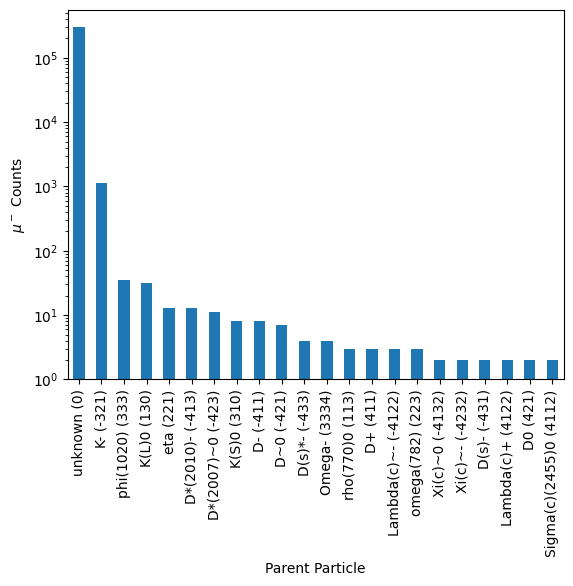

In [6]:
sel = particles.query("pdgid == 13")

counts = sel.mother_pdgid_cleaned.value_counts()
counts.index = counts.index.map(
    lambda pid: (
        f"{Particle.from_pdgid(pid).name} ({pid})" if pid != 0 else "unknown (0)"
    )
)
counts.plot(kind="bar", log=True)

plt.ylabel("$\mu^-$ Counts")
plt.xlabel("Parent Particle")

Here we see the big caviat of CORSIKA7's EHIST option: For a lot of particles (most probably only pions), it can't really tell the direct parent particle of the muon, so it get's classified as "unknown", with the non-existing pdgid 0.
It is important to use the column "mother_pdgid_cleaned" instead of "mother_pdgid", since EHIST is providing particles further up in the decay chain, then the direct parent and indicates this via the "Hadron Generation Counter". `panama` properly parses this and applies it in the `_cleaned` columns of the DataFrame.
**TLDR;** Unkowm are (most likely) either `\pi^+` or `\pi^-` mesons, remember to use `mother_pdgid_cleaned` instead of `mother_pdgid`.


Let's plot an energy distribution of the muons in the simulation:

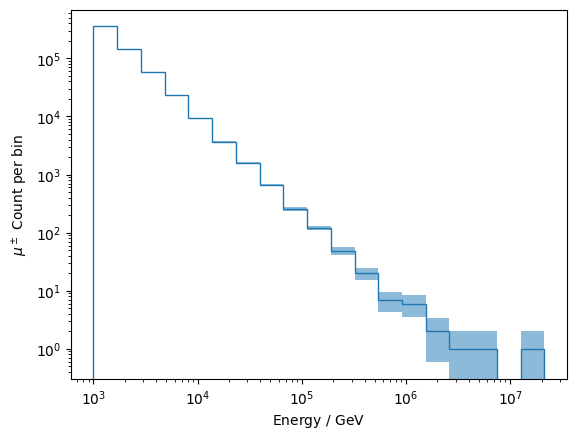

In [7]:
# Select all muons and anti-muons and histogram their energy
e = particles.query("pdgid in (13, -13)")["energy"]

# Create new plot
fig, ax = plt.subplots()

# Use logarithmically sized bins
bins = np.geomspace(e.min(), e.max(), 20)

# Get the counts in each bin
counts, _ = np.histogram(e, bins=bins)

# Plot hist and error bands
ax.stairs(
    counts,
    bins,
)
ax.fill_between(
    bins[1:], counts - np.sqrt(counts), counts + np.sqrt(counts), step="pre", alpha=0.5
)

# Add information and double log
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Energy / $\mathrm{GeV}$")
ax.set_ylabel("$\mu^\pm$ Count per bin")
None

Of course, this is not a real energy-distribution, since the simulation is just randomly sampled from a $E^{-1}$ power-law (as specified in the steering-card above). We just see the power-law distribution in the plot. 
To obtain a real simulation, we have to apply weights to the simulation. 
`panama` also provides functionality for that (See later in this notebook). 


### Exporting the data
Since `DAT` files are not the most efficient format, and more importantly, is not a standarized self-discribing format, we can also use `pandas` and `panama` to export the CORSIKA7 dataset to a different format:

In [8]:
output = "corsika_output/dataset.hdf5"
run_header.to_hdf(output, "run_header")
event_header.to_hdf(output, "event_header")
particles.to_hdf(output, "particles")

/tmp/ipykernel_117990/1262720920.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['observation_height'], dtype='object')]

  run_header.to_hdf(output, "run_header")


The warning is nothing to worry about, as the run_header is a very small object anyway. It stores the different heights of the observation levels as touples, which must be pickled so saving is less efficient. Pandas warns us about that.

We can now read in the simulation again, which should be faster and also does not require knowledge about the specific corsika DAT format, so it could even be used without `panama` or any CORSIKA7 knowledge at all.

In [9]:
run_header = pd.read_hdf("corsika_output/dataset.hdf5", "run_header")
event_header = pd.read_hdf("corsika_output/dataset.hdf5", "event_header")
particles = pd.read_hdf("corsika_output/dataset.hdf5", "particles")

In [10]:
event_header.shape

(4000, 107)

Good! That means that we retained all of the 4000 simulated events. In theory, we could delete the `DAT` files now. If disc-space is not a constrain, it can be a good idea to backup the original `DAT` files for debugging purposes. As for example the original rows containing the mother particles are dropped (at least if we read it with the options used here). In general, `panama` reads in the important information, so except in some constructed unlikely edge-cases, it is save to delete them. Let's look at their size for comparison:  

In [11]:
!du -h corsika_output
!du -h corsika_output/*.hdf5

401M	corsika_output
301M	corsika_output/dataset.hdf5


We see that actually, the hdf5 file is 214 MB, whereas the size of all DAT files is lower with only about 100MB. 
What went wrong? To factors: The hdf5 file actually holds more information: The column names and particle masses for example. Also a lot of the information is redundant: For convenience, the mass is given for every particle, although two muons obiously always have the same mass.
On the other hand, we did not turn on compression when generating the hdf5 file. Let's see how much we can compress it:

In [12]:
output = "corsika_output/dataset_compressed.hdf5"
run_header.to_hdf(output, "run_header", complevel=5)
event_header.to_hdf(output, "event_header", complevel=5)
particles.to_hdf(output, "particles", complevel=5)

/tmp/ipykernel_117990/1504898620.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['observation_height'], dtype='object')]

  run_header.to_hdf(output, "run_header", complevel=5)


In [13]:
!du -h corsika_output/*compressed.hdf5

81M	corsika_output/dataset_compressed.hdf5


This actually compresses the hdf5 files with more information to less space then the DAT files! Obviously, saving now took a much longer time. A smaller compression level (e.g. 5) might be a good compromise.

Reading will also take slightly longer (not as much as writing, though):

In [14]:
run_header = pd.read_hdf("corsika_output/dataset_compressed.hdf5", "run_header")
event_header = pd.read_hdf("corsika_output/dataset_compressed.hdf5", "event_header")
particles = pd.read_hdf("corsika_output/dataset_compressed.hdf5", "particles")

Of course, you can also use other formats to save the simulation, `pandas` is quite versatile in that regard. (You can even consider to export your simulation to excel)
If you want to be bleeding-edge modern, have a look at `.to_parquet()`.

`panama` provides a command line utility to convert DAT files to `hdf5` files, with `panama hdf5`. The default compression level there is 5.

### Weighting the Simulation
`panama` provides utilities to weight the simulation, to produce physical spectra.
For that, we have to assume a flux with which the cosmic rays arrive on top of the atmosphere. These are provided in the `fluxcomp` package (it's automatically installed with `panama`).

In [15]:
import fluxcomp

In [16]:
particles["weight_GSF"] = pn.get_weights(
    run_header,
    event_header,
    particles,
    model=fluxcomp.GlobalSplineFit(),
    proton_only=False,  # This controls if for example a helium is treated as 4 protons.
    # This means, that only the proton information of the MC is used (proton_only=True).
)

You can even combine multiple-datasets with different energy regions of different runs and correctly weight them with this function. 
The only thing which is currently not possible is to weigh simulations with overlapping energy-regions. The function will throw an error then.

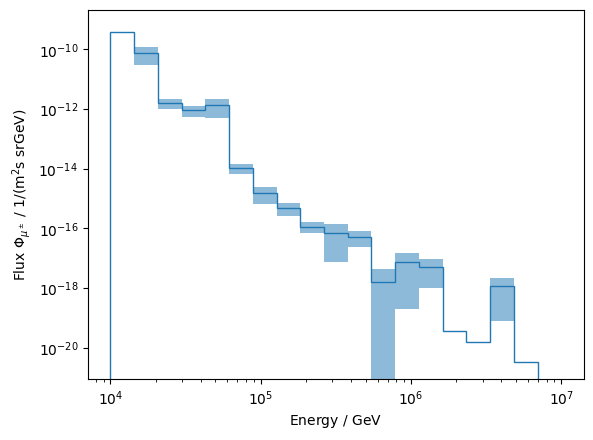

In [17]:
# Select all muons and anti-muons and histogram their energy
sel = particles.query("pdgid in (13, -13)")
e = sel["energy"]

# Create new plot
fig, ax = plt.subplots()

# Use logarithmically sized bins
# Since we only simulated between 1e4 and 1e9 GeV,
# Only these bounds make sense. (above 1e7, most muons come from 1e9 primaries and above)
bins = np.geomspace(1e4, 1e7, 20)

# Get the weighted counts (=flux) in each bin
flux, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"])
# The error for weighted histograms calculates as follows
err, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"] ** 2)
err = np.sqrt(err)

# The differential flux is more informative, so we convert to that
flux /= np.diff(bins)
err /= np.diff(bins)

# Plot hist and error bands
ax.stairs(
    flux,
    bins,
)
ax.fill_between(bins[1:], flux - err, flux + err, step="pre", alpha=0.5)

# Add information and double log
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Energy / $\mathrm{GeV}$")
ax.set_ylabel("Flux $\Phi_{\mu^\pm}\ /\ 1/(\mathrm{m^2 s\ sr GeV})$")
None

#### Examining the prompt spectrum

We can now also only select prompt particles and plot their spectrum:

In [18]:
# This key is provided by default under "is_prompt", when using "additional_columns=True" when reading in from dat
# pn.prompt also features other definitions of prompt with a similar interace. It is well-documented.
particles["is_prompt_lifetime"] = pn.prompt.is_prompt_lifetime_limit(particles)

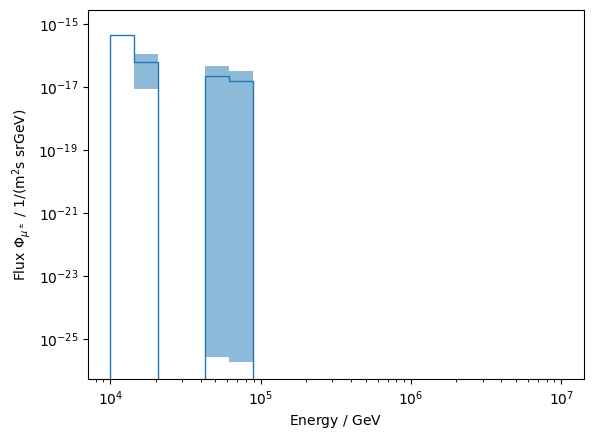

In [19]:
# Select all muons and anti-muons and histogram their energy
sel = particles.query("pdgid in (13, -13) and is_prompt_lifetime == True")
e = sel["energy"]

# Create new plot
fig, ax = plt.subplots()

# Use logarithmically sized bins
# Since we only simulated between 1e4 and 1e9 GeV,
# Only these bounds make sense. (above 1e7, most muons come from 1e9 primaries and above)
bins = np.geomspace(1e4, 1e7, 20)

# Get the weighted counts (=flux) in each bin
flux, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"])
# The error for weighted histograms calculates as follows
err, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"] ** 2)
err = np.sqrt(err)

# The differential flux is more informative, so we convert to that
flux /= np.diff(bins)
err /= np.diff(bins)

# Plot hist and error bands
ax.stairs(
    flux,
    bins,
)
ax.fill_between(bins[1:], flux - err, flux + err, step="pre", alpha=0.5)

# Add information and double log
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Energy / $\mathrm{GeV}$")
ax.set_ylabel("Flux $\Phi_{\mu^\pm}\ /\ 1/(\mathrm{m^2 s\ sr GeV})$")
None

We see, that the simulation lacks of statistics. At about 100_000 datapoints with a similar setting, the spectra become good.

**That's it!** These was a introduction in all features in `panama`. Each function provides almost always more options, so have a look at the documentation.  
Should you encounter bugs or have suggestions for improvement, please open an [issue](https://github.com/The-Ludwig/PANAMA/issues) or a [pull request](https://github.com/The-Ludwig/PANAMA/pulls) and get in touch.